In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 1000
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

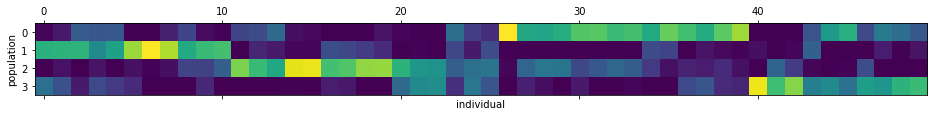

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 1000, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [8]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


In [9]:
dp_prior_alpha = prior_params_dict['dp_prior_alpha']
allele_prior_alpha = prior_params_dict['allele_prior_alpha']
allele_prior_beta = prior_params_dict['allele_prior_beta']

# Get VB params 

In [10]:
k_approx = 12

In [11]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [12]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (1000, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [13]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 412)

In [14]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

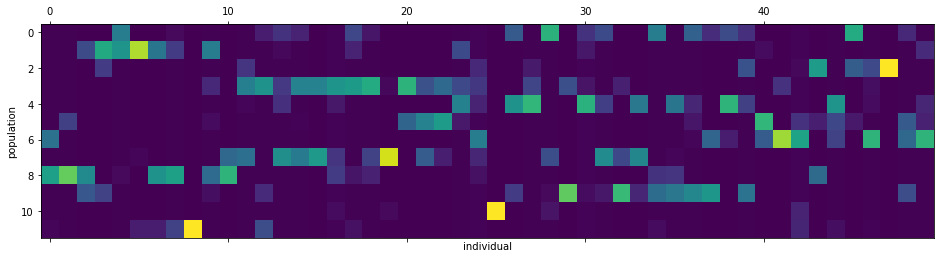

In [15]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Cavi updates

In [16]:
e_log_sticks, e_log_1m_sticks, \
        e_log_pop_freq, e_log_1m_pop_freq = \
            structure_model_lib.get_moments_from_vb_params_dict(
                vb_params_dict, gh_loc, gh_weights)

### Check population updates

In [17]:
_, _, beta_params = \
    cavi_lib.update_pop_beta(g_obs,
                    e_log_pop_freq, e_log_1m_pop_freq,
                    e_log_sticks, e_log_1m_sticks,
                    dp_prior_alpha, allele_prior_alpha,
                    allele_prior_beta)

In [18]:
import vb_lib.cavi_lib_old as cavi_lib_old

In [19]:
e_z = cavi_lib_old.update_z(g_obs, e_log_sticks, e_log_1m_sticks, e_log_pop_freq,
                                e_log_1m_pop_freq)

In [20]:
_, _, beta_params2 = \
    cavi_lib_old.update_pop_beta(g_obs, e_z,
                    e_log_sticks, e_log_1m_sticks,
                    dp_prior_alpha, allele_prior_alpha,
                    allele_prior_beta)

In [21]:
np.abs(beta_params - beta_params2).max()

DeviceArray(3.55271368e-15, dtype=float64)

### Check stick updates

In [22]:
_, _, stick_beta = cavi_lib.update_stick_beta(g_obs,
                                            e_log_pop_freq, e_log_1m_pop_freq,
                                            e_log_sticks, e_log_1m_sticks,
                                            dp_prior_alpha, allele_prior_alpha,
                                            allele_prior_beta)

In [23]:
e_z = cavi_lib_old.update_z(g_obs, e_log_sticks, e_log_1m_sticks, e_log_pop_freq,
                                e_log_1m_pop_freq)

_, _, stick_beta2 = \
    cavi_lib_old.update_stick_beta(g_obs, e_z,
                    e_log_pop_freq, e_log_1m_pop_freq,
                    dp_prior_alpha, allele_prior_alpha,
                    allele_prior_beta)

In [24]:
np.abs(stick_beta - stick_beta2).max()

DeviceArray(3.18323146e-12, dtype=float64)